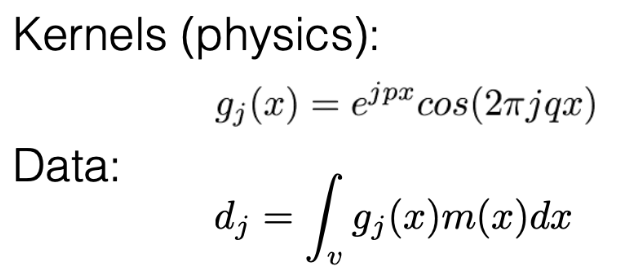

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) 
        * np.cos(2 * np.pi * j * q * x) 
    )

In [3]:
n_cells = 100
x_nodes = np.linspace(0, 1, n_cells+1)

In [4]:
n_kernels = 20 

p = -0.05
q = 0.1
j0 = 1
jN = 30

j_values = np.linspace(j0, jN, n_kernels)

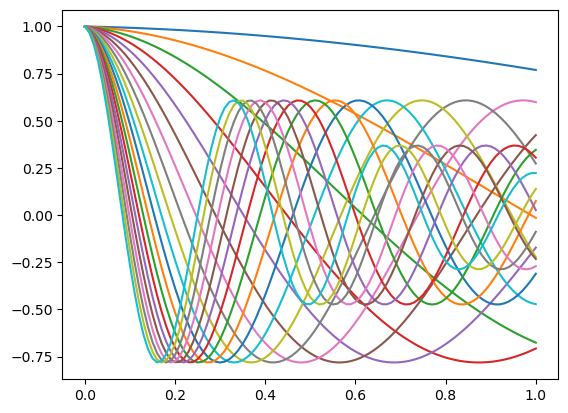

In [5]:
for jk in j_values: 
    g = kernel_function(x_nodes, j=jk, p=p, q=q)
    plt.plot(x_nodes, g)

In [6]:
delta_x = np.diff(x_nodes) #x_nodes[1:] - x_nodes[:-1]
x_centers = x_nodes[:-1] + delta_x / 2

(0.0, 0.5)

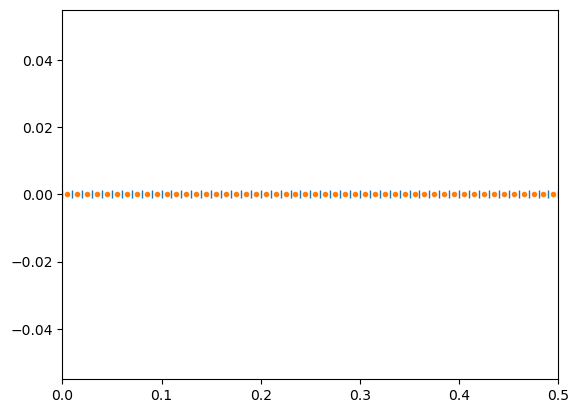

In [7]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_nodes, np.zeros_like(x_nodes), "|")
ax.plot(x_centers, np.zeros_like(x_centers), ".")
ax.set_xlim([0, 0.5])

## define our model 
- boxcar and a gaussian 

In [8]:
def get_model(
    x_centers, 
    x_boxcar_min=0.15, x_boxcar_max=0.25, amplitude_boxcar=0.5,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
): 
    model = np.zeros_like(x_centers) 

    # boxcar
    inds_boxcar = (x_centers > x_boxcar_min) & (x_centers < x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar

    # define gaussian 
    def gaussian(x, x0, sigma): 
        return np.exp( - (x-x0)**2 / (2 * sigma**2))

    return model + amplitude_gaussian * gaussian(x_centers, x0_gaussian, sigma_gaussian) 

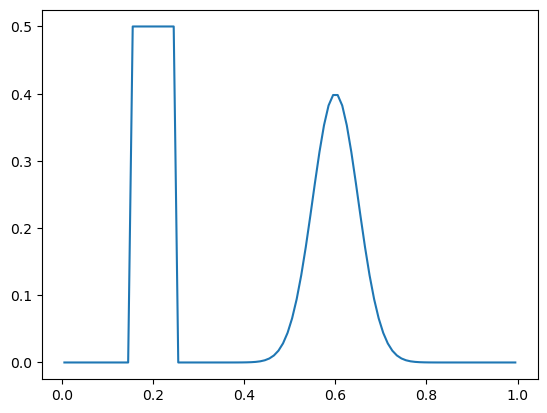

In [9]:
model = get_model(x_centers)
plt.plot(x_centers, model)

In [10]:
def get_G(x_nodes, n_kernels=20, p=-0.05, q=0.1, j0=1, jN=30):

    n_nodes = len(x_nodes)
    n_centers = n_nodes - 1

    j_values = np.linspace(j0, jN, n_kernels)
    
    # create an empty G 
    Gnodes = np.zeros((n_nodes, n_kernels))

    # fill with kernels 
    for k, jk in enumerate(j_values): 
        Gnodes[:, k] = kernel_function(x_nodes, j=jk, p=p, q=q)
        
    # averaging matrix 
    ave = sp.spdiags(0.5*np.vstack([np.ones(n_nodes), np.ones(n_nodes)]), [0, 1],m=n_centers, n=n_nodes)
    
    delta_x = np.diff(x_nodes)
    
    return (ave @ Gnodes).T @ sp.diags(delta_x)

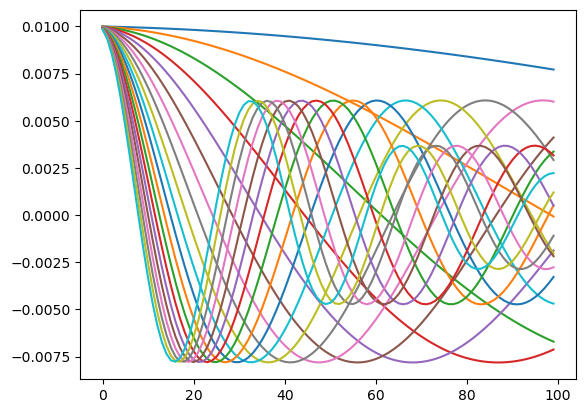

In [11]:
G = get_G(x_nodes)
plt.plot(G.T); 

In [12]:
m = get_model(
    x_centers, 
    x_boxcar_min=0.2, x_boxcar_max=0.25, amplitude_boxcar=0.7,
    x0_gaussian=0.6, sigma_gaussian=0.05, amplitude_gaussian=0.4 
)
G = get_G(x_nodes, n_kernels=20, p=-0.1, q=0.1, j0=1, jN=40)
d = G @ m

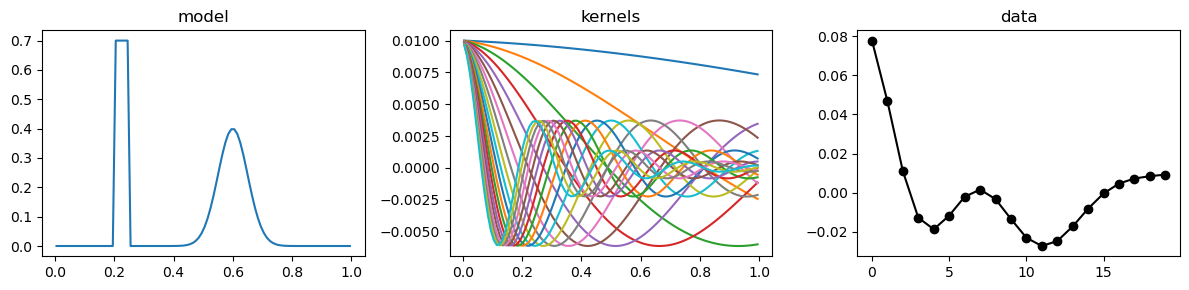

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(x_centers, m)
ax[1].plot(x_centers, G.T)
ax[2].plot(d, "-o", color="k")

ax[0].set_title("model")
ax[1].set_title("kernels")
ax[2].set_title("data")

plt.tight_layout()

In [21]:
A = G.T @ G + 1e-4 * np.eye(len(x_centers))
rhs = G.T @ d

mrec = np.linalg.solve(A, rhs)

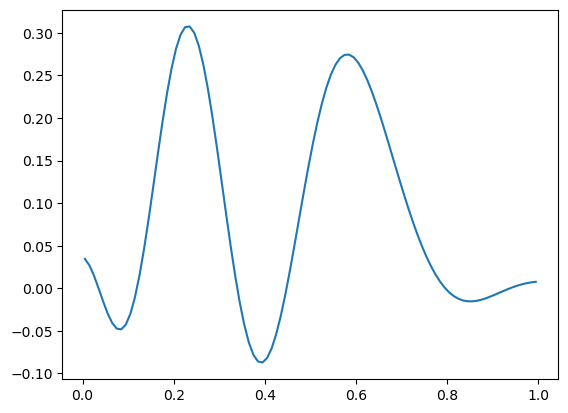

In [22]:
plt.plot(x_centers, mrec)

In [23]:
eigv, eig_vecotrs = np.linalg.eig(A)

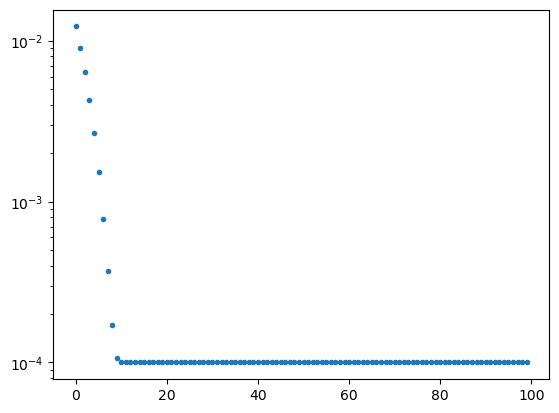

In [24]:
plt.semilogy(np.abs(eigv), ".")

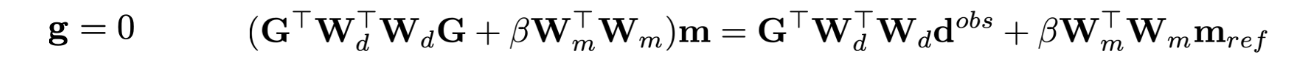

In [25]:
dobs = d # + gaussian noise

In [26]:
std = 1e-4 
Wd = 1/std * sp.eye(len(dobs))

In [27]:
Wm = sp.diags(np.sqrt(delta_x))

In [46]:
# def get_H(beta, std=1e-4): 
beta = 1e4
mref = np.zeros_like(m) 

Wd = 1/std * sp.eye(len(dobs))
H = (G.T @ Wd.T @ Wd @ G + beta * Wm.T @ Wm) 
rhs = G.T @ Wd.T @ Wd @ dobs + beta * Wm.T @ Wm @ mref

In [47]:
mrec = np.linalg.solve(H, rhs)
# eig, eig_v = np.linalg.eig(H)
# plt.semilogy(np.abs(eig), '.')

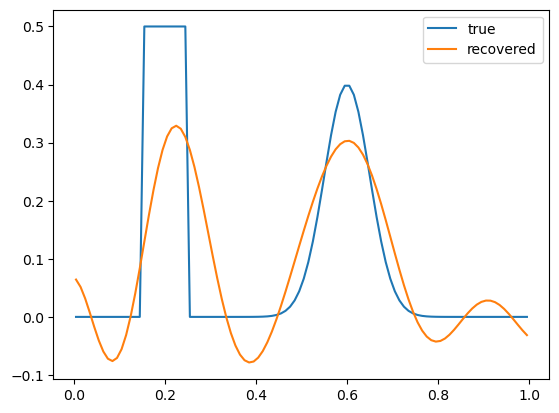

In [50]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_centers, model, label="true")
ax.plot(x_centers, mrec, label="recovered")
ax.legend()